In [1]:
import pandas as pd
import numpy as np

highlighted_columns = [
    'DX_bl',           # Baseline Dx
    'AGE',             # Age
    'PTGENDER',        # Sex
    'APOE4',           # ApoE4
    'ADAS13_bl',       # ADAS 13
    'MMSE_bl',         # MMSE
    #'RAVLT_bl',        # RAVLT (forgetting) at baseline
    'RAVLT_immediate_bl', # RAVLT Immediate (sum of 5 trials)
    'Ventricles_bl',   # UCSF Ventricles
    'Hippocampus_bl',  # UCSF Hippocampus
    'WholeBrain_bl',   # UCSF WholeBrain
    'Entorhinal_bl',   # UCSF Entorhinal
    'Fusiform_bl',     # UCSF Fusiform
    'MidTemp_bl',      # UCSF Med Temp
    'ICV_bl',          # UCSF ICV
    'EcogPtMem_bl',    # Pt Ecog - Mem
    'EcogPtLang_bl',   # Pt Ecog - Lang
    'EcogPtVisspat_bl', # Pt Ecog - Vis/Spat
    'EcogPtPlan_bl',   # Pt Ecog - Plan
    'EcogPtOrgan_bl',  # Pt Ecog - Organ
    'EcogPtDivatt_bl', # Pt Ecog - Div atten
    'EcogPtTotal_bl',  # Pt Ecog - Total
    'EcogSPMem_bl',    # SP Ecog - Mem
    'EcogSPLang_bl',   # SP Ecog - Lang
    'EcogSPVisspat_bl', # SP Ecog - Vis/Spat
    'EcogSPPlan_bl',   # SP Ecog - Plan
    'EcogSPOrgan_bl',  # SP Ecog - Organ
    'EcogSPTotal_bl',  # SP Ecog - Total
    'TAU_bl',          # CSF TAU
    'ADASQ4_bl',       # ADAS Delayed Word Recall
    'RAVLT_learning_bl', # RAVLT Learning (trial 5 - trial 1)
    'RAVLT_forgetting_bl', # RAVLT Forgetting (trial 5 - delayed)
    'RAVLT_perc_forgetting_bl', # RAVLT Percent Forgetting
    'LDELTOTAL_BL'     # Logical Memory - Delayed Recall

,'DX_bl(Modified)'
#,"CCI1","CCI2","CCI3","CCI4","CCI5","CCI6","CCI7","CCI8","CCI9","CCI10","CCI11","CCI12","CCI13","CCI14","CCI15","CCI16","CCI17","CCI18","CCI19","CCI20"
    ]
dfpredicted = pd.read_csv("Output_K=3_Fold=0/predicted_labels.csv")
df_pet = pd.read_csv("pet.csv")
df_demo = pd.read_csv("subject_demographics.csv")
df_cci = pd.read_csv("All_Subjects_CCI_22Oct2024.csv")
# Define the mapping
dx_mapping = {
    'LMCI': 'MCI (EMCI,LMCI)',
    'EMCI': 'MCI (EMCI,LMCI)',
    'CN': 'Normal (CN,SMC)',
    'SMC': 'Normal (CN,SMC)',
    'AD': 'AD'
}

# Create the new column by mapping
df_demo['DX_bl(Modified)'] = df_demo['DX_bl'].map(dx_mapping)
# Merge on subjectid and rid
df_demo_predicted = pd.merge(df_demo, dfpredicted, left_on='RID', right_on='SubjectID', how='inner')
# Merge on subjectid and rid
df_demo_predicted_CCI = pd.merge(df_demo_predicted, df_cci, left_on='RID', right_on='RID', how='inner')
df_demo_predicted['Subtype'] = df_demo_predicted['PredictedLabel3'].map({0: 'S1', 1: 'S2', 2: 'S3'})
df_subset = df_demo_predicted[['AGE', 'PTGENDER', 'DX_bl', 'APOE4', 'Subtype']]
df_subset


ecog_patient_vars = {
    'EcogPtMem_bl': 'Memory',
    'EcogPtLang_bl': 'Language',
    'EcogPtVisspat_bl': 'Visuospatial',
    'EcogPtPlan_bl': 'Planning',
    'EcogPtOrgan_bl': 'Organization',
    'EcogPtDivatt_bl': 'Divided Attention',
    'EcogPtTotal_bl': 'Total Score'
}

ecog_partner_vars = {
    'EcogSPMem_bl': 'Memory',
    'EcogSPLang_bl': 'Language',
    'EcogSPVisspat_bl': 'Visuospatial',
    'EcogSPPlan_bl': 'Planning',
    'EcogSPOrgan_bl': 'Organization',
    'EcogSPDivatt_bl': 'Divided Attention',
    'EcogSPTotal_bl': 'Total Score'
}

cognitive_vars = {
    'MMSE_bl': 'MMSE (Global Cognition)',
    'RAVLT_immediate_bl': 'RAVLT Immediate Recall',
    'RAVLT_learning_bl': 'RAVLT Learning',
    'RAVLT_forgetting_bl': 'RAVLT Forgetting',
    'RAVLT_perc_forgetting_bl': 'RAVLT % Forgetting',
    'LDELTOTAL_BL': 'Logical Memory Delayed',
    'ADAS13_bl': 'ADAS-Cog 13',
    'ADASQ4_bl': 'ADAS Word Recognition'
}


In [2]:

# Assume df_demo_predicted is already loaded
df_anatomical = df_demo_predicted.copy()

# Get all variables
all_vars_to_check = list(ecog_patient_vars.keys()) + list(ecog_partner_vars.keys()) + list(cognitive_vars.keys())
df_anatomical = df_anatomical.dropna(subset=all_vars_to_check)

print("Filtered dataset shape:", df_anatomical.shape)

Filtered dataset shape: (254, 122)


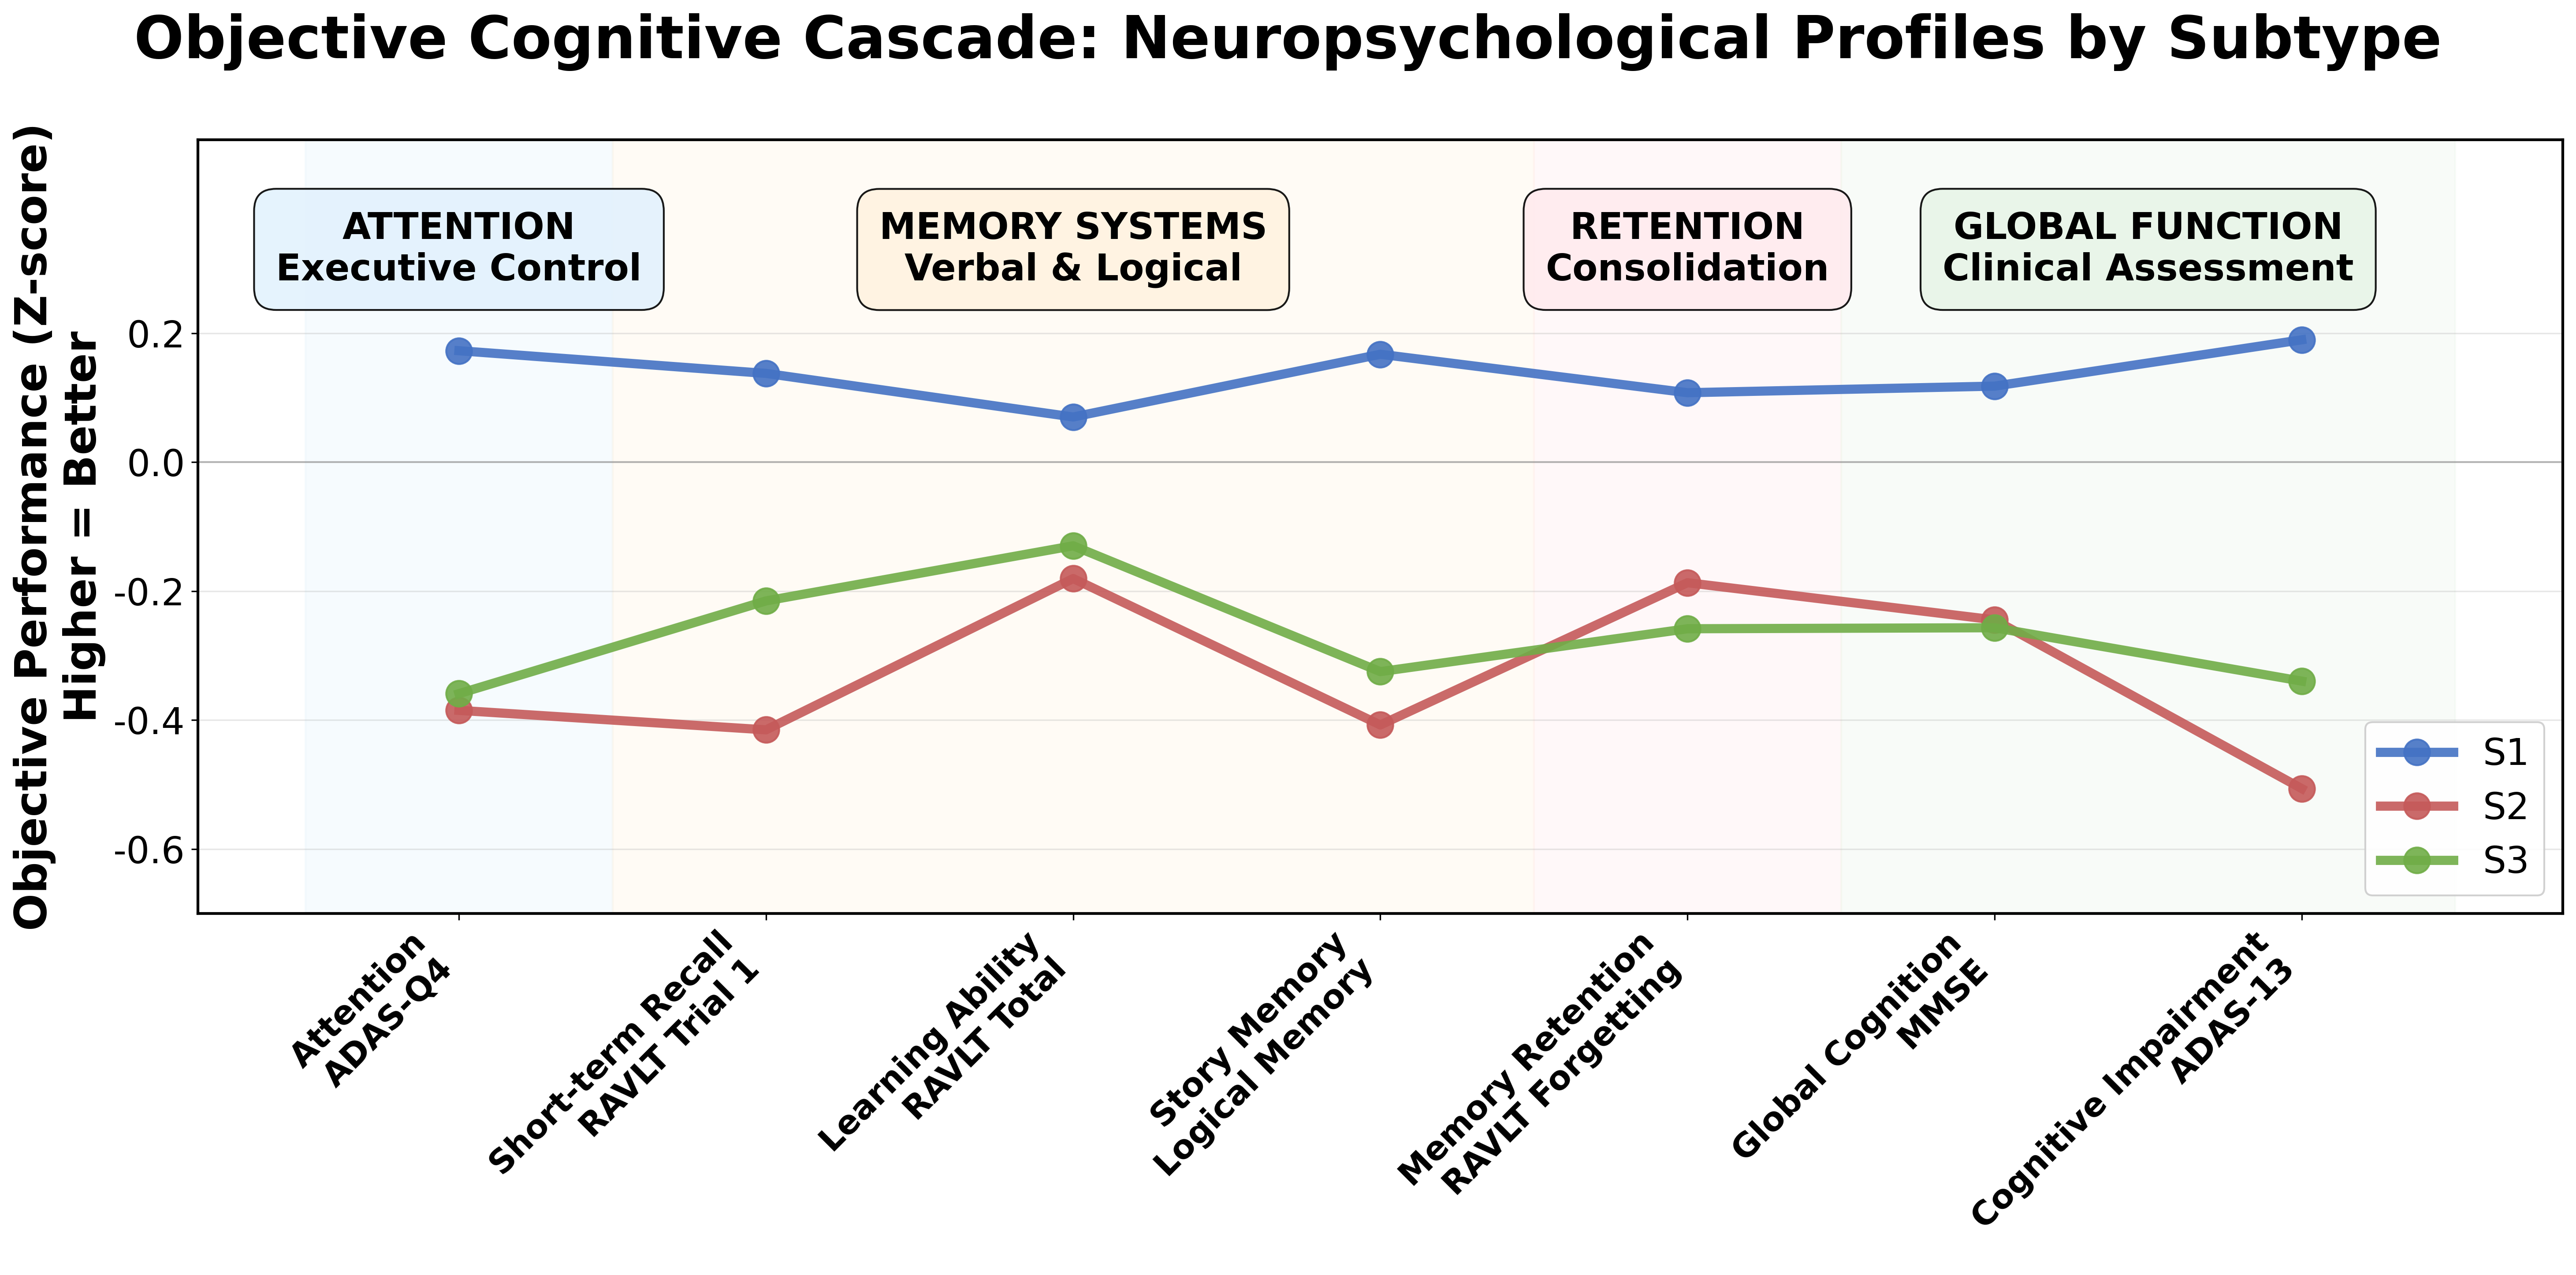

Z-SCORE NORMALIZATION EXPLANATION

Why Z-score normalization is ESSENTIAL:

1. DIFFERENT SCALES:
   • MMSE: 0-30 points (higher = better)
   • ADAS-13: 0-85 points (higher = WORSE)
   • RAVLT: 0-15 words per trial (higher = better)

2. WITHOUT NORMALIZATION:
   Example scores: MMSE=28, ADAS=15, RAVLT=12
   → Plot would be dominated by MMSE (28), making patterns invisible
   → Cannot compare across cognitive domains

3. WITH Z-SCORES:
   • All tests converted to common scale (-2 to +2)
   • Shows relative performance vs population mean
   • Higher z-score = better performance (after flipping ADAS/forgetting)
   • Reveals cognitive 'signatures' for each subtype

4. Z-SCORE FORMULA:
   z = (individual_score - population_mean) / population_std
   • z=0: Average performance
   • z>0: Above average
   • z<0: Below average

This normalization is REQUIRED for meaningful comparison!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 300
subtype_colors = {'S1': '#4472C4', 'S2': '#C55A5A', 'S3': '#70AD47'}

# =============================================================================
# PLOT: OBJECTIVE MEMORY CASCADE
# =============================================================================

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle('Objective Cognitive Cascade: Neuropsychological Profiles by Subtype', 
             fontsize=32, fontweight='bold')

# Updated cognitive domain + test name labels with clearer descriptions
memory_cascade = {
    'Attention\nADAS-Q4': 'ADASQ4_bl',
    'Short-term Recall\nRAVLT Trial 1': 'RAVLT_immediate_bl',
    'Learning Ability\nRAVLT Total': 'RAVLT_learning_bl',
    'Story Memory\nLogical Memory': 'LDELTOTAL_BL',
    'Memory Retention\nRAVLT Forgetting': 'RAVLT_forgetting_bl',
    'Global Cognition\nMMSE': 'MMSE_bl',
    'Cognitive Impairment\nADAS-13': 'ADAS13_bl'
}

# Calculate z-scores with proper normalization
memory_profiles = {}
for subtype in ['S1', 'S2', 'S3']:
    profile = []
    for stage, var in memory_cascade.items():
        if var in df_anatomical.columns:
            subtype_data = df_anatomical[df_anatomical['Subtype'] == subtype][var].dropna()
            if len(subtype_data) > 0:
                mean_score = subtype_data.mean()
                all_scores = df_anatomical[var].dropna()
                z_score = (mean_score - all_scores.mean()) / all_scores.std()
                # Flip scores so higher always = better performance
                if any(term in var.lower() for term in ['adas', 'forgetting']):
                    z_score = -z_score  # Flip ADAS and forgetting scores
                profile.append(z_score)
            else:
                profile.append(0)
        else:
            print(f"Warning: {var} not found in dataframe.")
            profile.append(0)
    memory_profiles[subtype] = profile

# Plot memory cascade with enhanced styling
x_positions = np.arange(len(memory_cascade))
for subtype, profile in memory_profiles.items():
    ax.plot(x_positions, profile, 'o-', color=subtype_colors[subtype], 
           linewidth=5, markersize=14, label=subtype, alpha=0.9)

# Add cognitive architecture stage bands
arch_stages = [
    {'start': -0.5, 'end': 0.5, 'color': '#E3F2FD', 'label': 'ATTENTION\nExecutive Control'},
    {'start': 0.5, 'end': 3.5, 'color': '#FFF3E0', 'label': 'MEMORY SYSTEMS\nVerbal & Logical'},
    {'start': 3.5, 'end': 4.5, 'color': '#FFEBEE', 'label': 'RETENTION\nConsolidation'},
    {'start': 4.5, 'end': 6.5, 'color': '#E8F5E8', 'label': 'GLOBAL FUNCTION\nClinical Assessment'}
]

for stage in arch_stages:
    ax.axvspan(stage['start'], stage['end'], alpha=0.3, color=stage['color'])
    mid_point = (stage['start'] + stage['end']) / 2
    ax.text(mid_point, 0.33, stage['label'], ha='center', va='center', 
           fontweight='bold', fontsize=20,
           bbox=dict(boxstyle='round,pad=0.6', facecolor=stage['color'], alpha=0.9))

# Customize ticks and labels with 45-degree rotation
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
ax.set_xticks(x_positions)
ax.set_xticklabels(list(memory_cascade.keys()), fontweight='bold', fontsize=18, 
                   rotation=45, ha='right')  # Changed to 45-degree rotation
ax.set_ylabel('Objective Performance (Z-score)\nHigher = Better', fontweight='bold', fontsize=24)

# Custom spaced y-ticks with 0.2 interval
yticks = np.arange(-0.6, 0.4, 0.2)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=20)

# Plot final formatting
ax.legend(loc='lower right', fontsize=20, framealpha=0.9)
ax.grid(alpha=0.3, axis='y')
ax.set_ylim(-0.7, 0.5)

plt.tight_layout()
plt.savefig("objective_memory_cascade_updated.pdf", format='pdf', bbox_inches='tight')
plt.show()

# =============================================================================
# EXPLANATION OF Z-SCORE NORMALIZATION
# =============================================================================

print("="*60)
print("Z-SCORE NORMALIZATION EXPLANATION")
print("="*60)

print("\nWhy Z-score normalization is ESSENTIAL:")
print("\n1. DIFFERENT SCALES:")
print("   • MMSE: 0-30 points (higher = better)")
print("   • ADAS-13: 0-85 points (higher = WORSE)")
print("   • RAVLT: 0-15 words per trial (higher = better)")

print("\n2. WITHOUT NORMALIZATION:")
print("   Example scores: MMSE=28, ADAS=15, RAVLT=12")
print("   → Plot would be dominated by MMSE (28), making patterns invisible")
print("   → Cannot compare across cognitive domains")

print("\n3. WITH Z-SCORES:")
print("   • All tests converted to common scale (-2 to +2)")
print("   • Shows relative performance vs population mean")
print("   • Higher z-score = better performance (after flipping ADAS/forgetting)")
print("   • Reveals cognitive 'signatures' for each subtype")

print("\n4. Z-SCORE FORMULA:")
print("   z = (individual_score - population_mean) / population_std")
print("   • z=0: Average performance")
print("   • z>0: Above average")
print("   • z<0: Below average")

print("\nThis normalization is REQUIRED for meaningful comparison!")
print("="*60)

COGNITIVE TEST SCALE ANALYSIS - PROVING NORMALIZATION IS REQUIRED

1. DESCRIPTIVE STATISTICS FOR EACH COGNITIVE TEST:
------------------------------------------------------------

Attention (ADAS-Q4):
  • Range: 0.0 to 10.0 (span: 10.0)
  • Mean ± SD: 3.66 ± 2.43
  • Sample size: 254

Short-term Recall (RAVLT Trial 1):
  • Range: 10.0 to 70.0 (span: 60.0)
  • Mean ± SD: 41.70 ± 11.70
  • Sample size: 254

Learning Ability (RAVLT Total):
  • Range: 0.0 to 11.0 (span: 11.0)
  • Mean ± SD: 5.50 ± 2.60
  • Sample size: 254

Story Memory (Logical Memory):
  • Range: 0.0 to 23.0 (span: 23.0)
  • Mean ± SD: 10.17 ± 4.48
  • Sample size: 254

Memory Retention (RAVLT Forgetting):
  • Range: -2.0 to 15.0 (span: 17.0)
  • Mean ± SD: 4.26 ± 2.64
  • Sample size: 254

Global Cognition (MMSE):
  • Range: 18.0 to 30.0 (span: 12.0)
  • Mean ± SD: 28.50 ± 1.77
  • Sample size: 254

Cognitive Impairment (ADAS-13):
  • Range: 0.7 to 39.0 (span: 38.3)
  • Mean ± SD: 11.48 ± 6.61
  • Sample size: 254

2. S

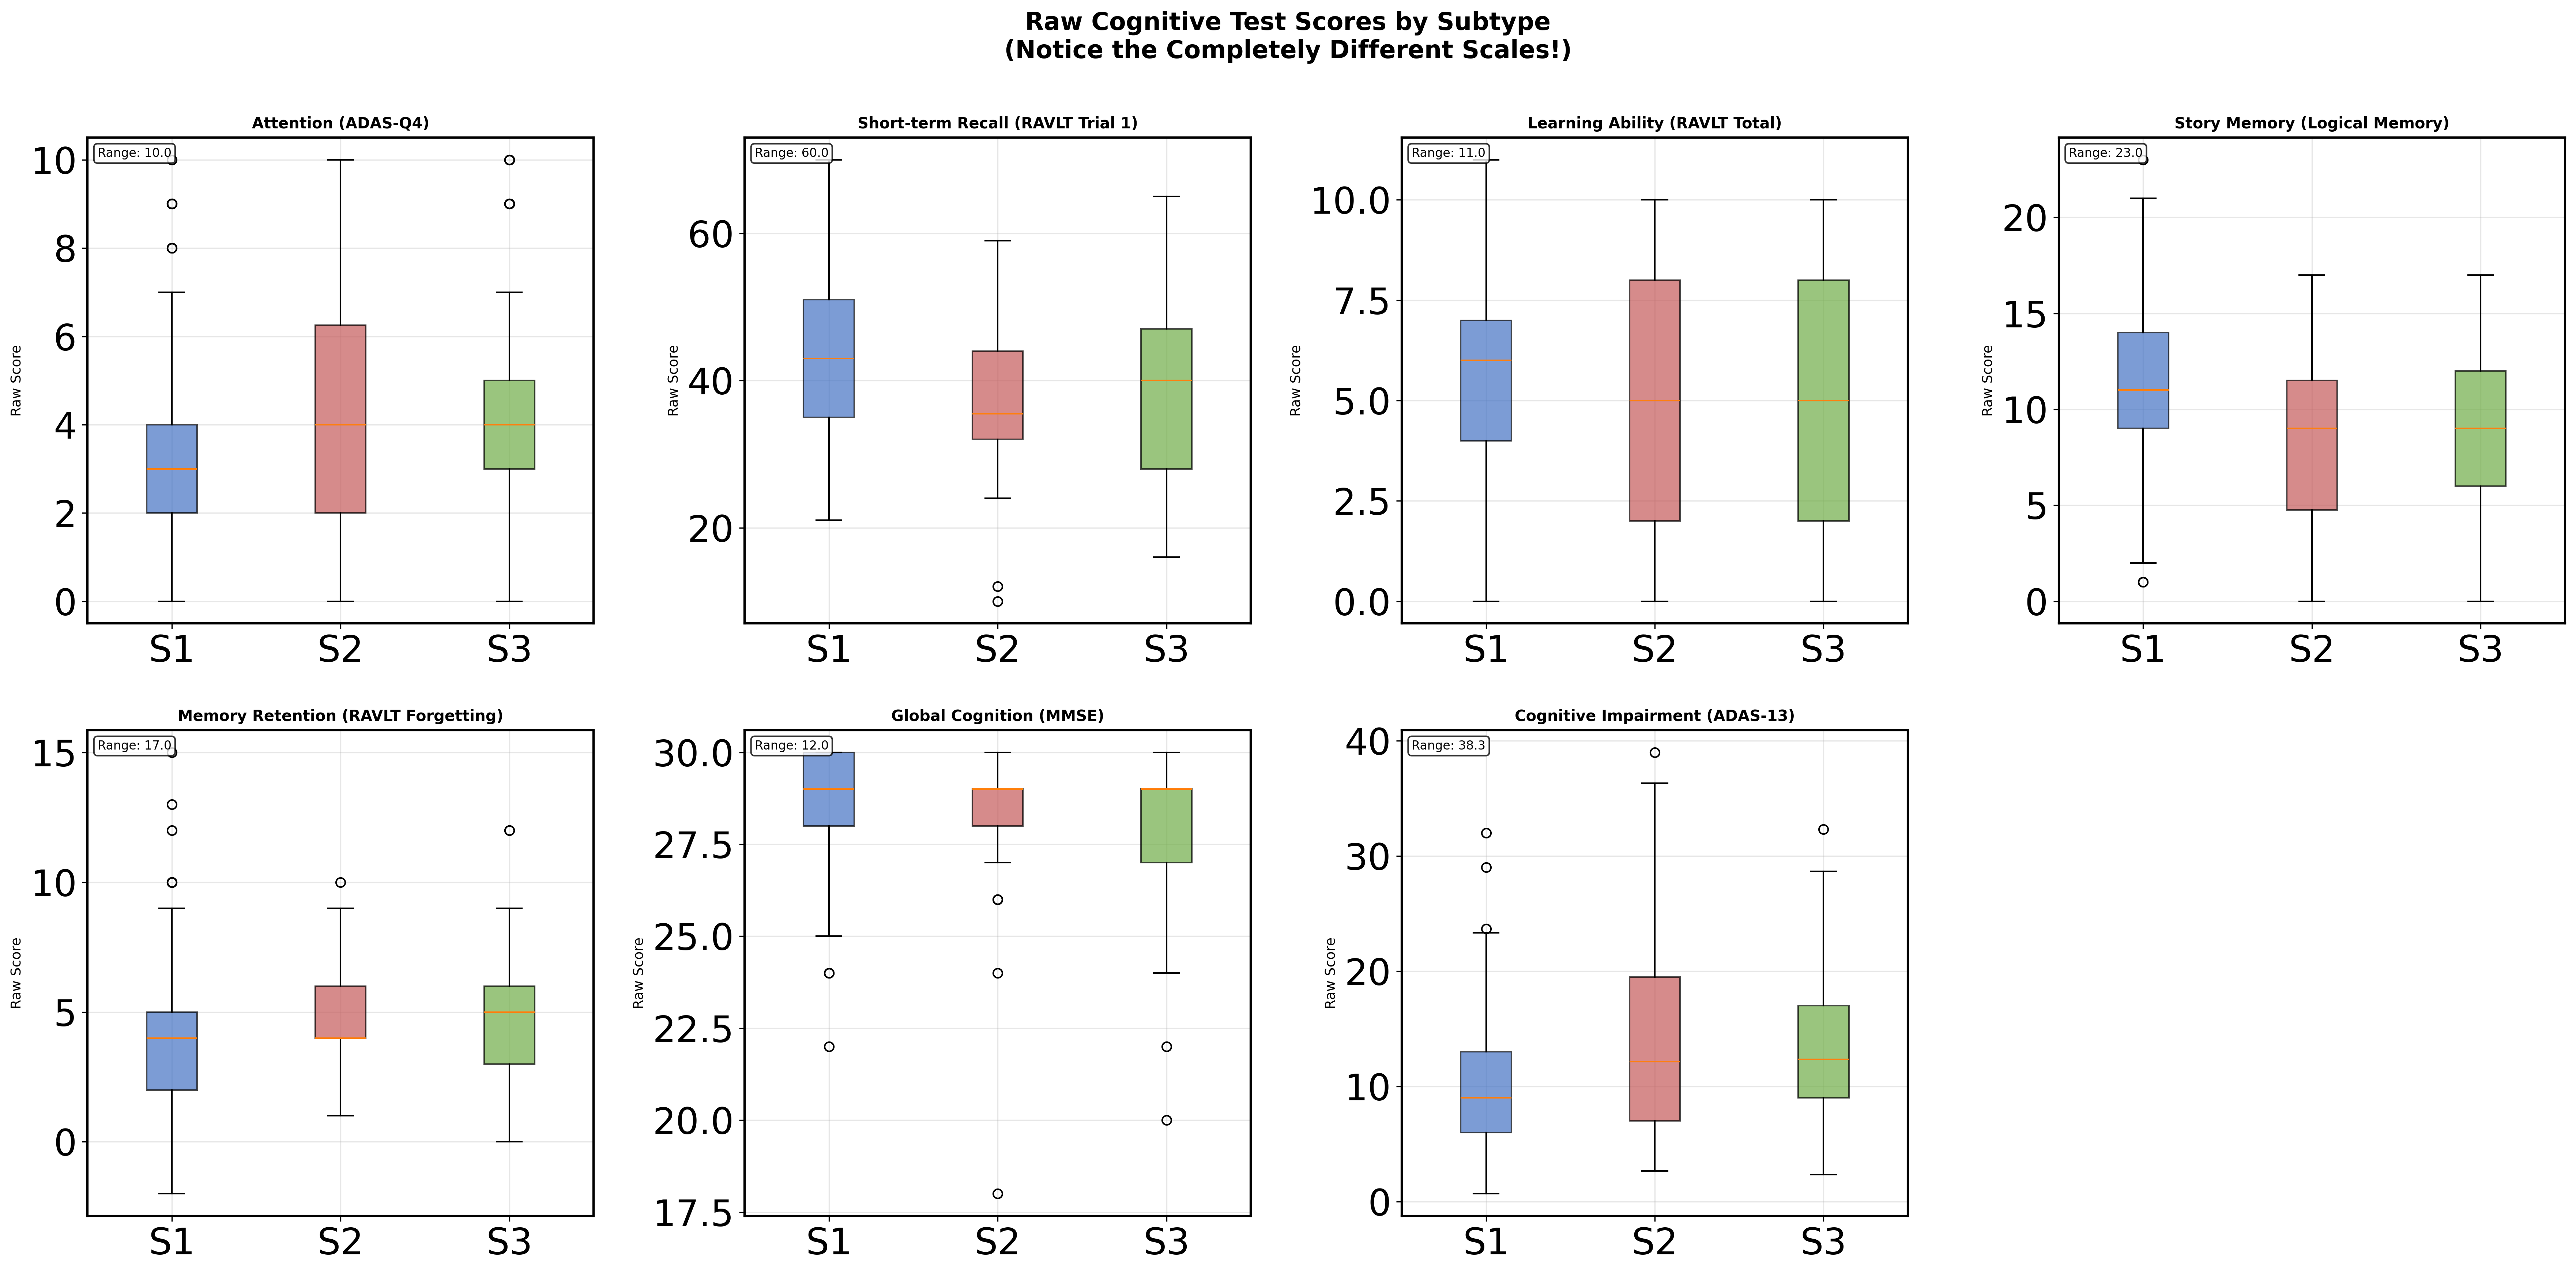


5. CONCLUSION: WHY NORMALIZATION IS ABSOLUTELY REQUIRED
------------------------------------------------------------

✗ WITHOUT NORMALIZATION:
  • Impossible to compare tests with different scales
  • Visual plots would be dominated by tests with larger ranges
  • Mixed scoring directions (some higher=better, some higher=worse)
  • Cannot identify cognitive patterns across domains

✓ WITH Z-SCORE NORMALIZATION:
  • All tests converted to common scale (typically -2 to +2)
  • Standardized direction (all become higher=better)
  • Shows relative performance vs population mean
  • Enables meaningful cross-domain comparison
  • Reveals cognitive 'signatures' for each subtype

📊 SCALE EVIDENCE:
  • 6.0x difference between largest and smallest ranges
  • Mixed scoring directions require reversal
  • Raw comparison would be scientifically meaningless!



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# ANALYZE COGNITIVE TEST SCALES IN df_anatomical
# =============================================================================

print("="*80)
print("COGNITIVE TEST SCALE ANALYSIS - PROVING NORMALIZATION IS REQUIRED")
print("="*80)

# Define the cognitive measures from your memory cascade
cognitive_measures = {
    'ADASQ4_bl': 'Attention (ADAS-Q4)',
    'RAVLT_immediate_bl': 'Short-term Recall (RAVLT Trial 1)', 
    'RAVLT_learning_bl': 'Learning Ability (RAVLT Total)',
    'LDELTOTAL_BL': 'Story Memory (Logical Memory)',
    'RAVLT_forgetting_bl': 'Memory Retention (RAVLT Forgetting)',
    'MMSE_bl': 'Global Cognition (MMSE)',
    'ADAS13_bl': 'Cognitive Impairment (ADAS-13)'
}

print("\n1. DESCRIPTIVE STATISTICS FOR EACH COGNITIVE TEST:")
print("-" * 60)

scale_comparison = {}
for var, description in cognitive_measures.items():
    if var in df_anatomical.columns:
        data = df_anatomical[var].dropna()
        if len(data) > 0:
            stats = {
                'count': len(data),
                'min': data.min(),
                'max': data.max(),
                'mean': data.mean(),
                'std': data.std(),
                'range': data.max() - data.min()
            }
            scale_comparison[var] = stats
            
            print(f"\n{description}:")
            print(f"  • Range: {stats['min']:.1f} to {stats['max']:.1f} (span: {stats['range']:.1f})")
            print(f"  • Mean ± SD: {stats['mean']:.2f} ± {stats['std']:.2f}")
            print(f"  • Sample size: {stats['count']}")
        else:
            print(f"\n{description}: NO DATA AVAILABLE")
    else:
        print(f"\n{description}: VARIABLE NOT FOUND")

print("\n" + "="*80)
print("2. SCALE COMPARISON SUMMARY:")
print("-" * 60)

# Create comparison table
if scale_comparison:
    comparison_df = pd.DataFrame(scale_comparison).T
    comparison_df = comparison_df.round(2)
    
    print("\nRAW SCORE RANGES (Min - Max):")
    for var, description in cognitive_measures.items():
        if var in scale_comparison:
            stats = scale_comparison[var]
            print(f"  {description:35} : {stats['min']:6.1f} - {stats['max']:6.1f}")

    print(f"\nSCALE DIFFERENCES:")
    ranges = [stats['range'] for stats in scale_comparison.values()]
    max_range = max(ranges)
    min_range = min(ranges)
    print(f"  • Largest range: {max_range:.1f}")
    print(f"  • Smallest range: {min_range:.1f}")
    print(f"  • Ratio (largest/smallest): {max_range/min_range:.1f}x difference!")

print("\n" + "="*80)
print("3. DIRECTION OF SCORING:")
print("-" * 60)

scoring_directions = {
    'ADASQ4_bl': 'Higher = WORSE (error count)',
    'RAVLT_immediate_bl': 'Higher = BETTER (words recalled)',
    'RAVLT_learning_bl': 'Higher = BETTER (total learning)', 
    'LDELTOTAL_BL': 'Higher = BETTER (story recall)',
    'RAVLT_forgetting_bl': 'Higher = WORSE (more forgetting)',
    'MMSE_bl': 'Higher = BETTER (cognitive intact)',
    'ADAS13_bl': 'Higher = WORSE (more impairment)'
}

for var, direction in scoring_directions.items():
    if var in cognitive_measures:
        print(f"  {cognitive_measures[var]:35} : {direction}")

print("\n" + "="*80)
print("4. VISUALIZATION: RAW SCORES BY SUBTYPE")
print("-" * 60)

# Create visualization showing raw score differences
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

subtype_colors = {'S1': '#4472C4', 'S2': '#C55A5A', 'S3': '#70AD47'}

for i, (var, description) in enumerate(cognitive_measures.items()):
    if i < len(axes) and var in df_anatomical.columns:
        ax = axes[i]
        
        # Box plot by subtype
        data_by_subtype = []
        labels = []
        colors = []
        
        for subtype in ['S1', 'S2', 'S3']:
            subtype_data = df_anatomical[df_anatomical['Subtype'] == subtype][var].dropna()
            if len(subtype_data) > 0:
                data_by_subtype.append(subtype_data)
                labels.append(subtype)
                colors.append(subtype_colors[subtype])
        
        if data_by_subtype:
            bp = ax.boxplot(data_by_subtype, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
        
        ax.set_title(description, fontsize=10, fontweight='bold')
        ax.set_ylabel('Raw Score', fontsize=9)
        ax.grid(alpha=0.3)
        
        # Add range annotation
        if var in scale_comparison:
            range_val = scale_comparison[var]['range']
            ax.text(0.02, 0.98, f"Range: {range_val:.1f}", transform=ax.transAxes, 
                   verticalalignment='top', fontsize=8, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Remove empty subplots
for i in range(len(cognitive_measures), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Raw Cognitive Test Scores by Subtype\n(Notice the Completely Different Scales!)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("5. CONCLUSION: WHY NORMALIZATION IS ABSOLUTELY REQUIRED")
print("-" * 60)

print("\n✗ WITHOUT NORMALIZATION:")
print("  • Impossible to compare tests with different scales")
print("  • Visual plots would be dominated by tests with larger ranges")
print("  • Mixed scoring directions (some higher=better, some higher=worse)")
print("  • Cannot identify cognitive patterns across domains")

print("\n✓ WITH Z-SCORE NORMALIZATION:")
print("  • All tests converted to common scale (typically -2 to +2)")
print("  • Standardized direction (all become higher=better)")
print("  • Shows relative performance vs population mean")
print("  • Enables meaningful cross-domain comparison")
print("  • Reveals cognitive 'signatures' for each subtype")

if scale_comparison:
    ranges = [stats['range'] for stats in scale_comparison.values()]
    if ranges:
        print(f"\n📊 SCALE EVIDENCE:")
        print(f"  • {max(ranges)/min(ranges):.1f}x difference between largest and smallest ranges")
        print(f"  • Mixed scoring directions require reversal")
        print(f"  • Raw comparison would be scientifically meaningless!")

print("\n" + "="*80)

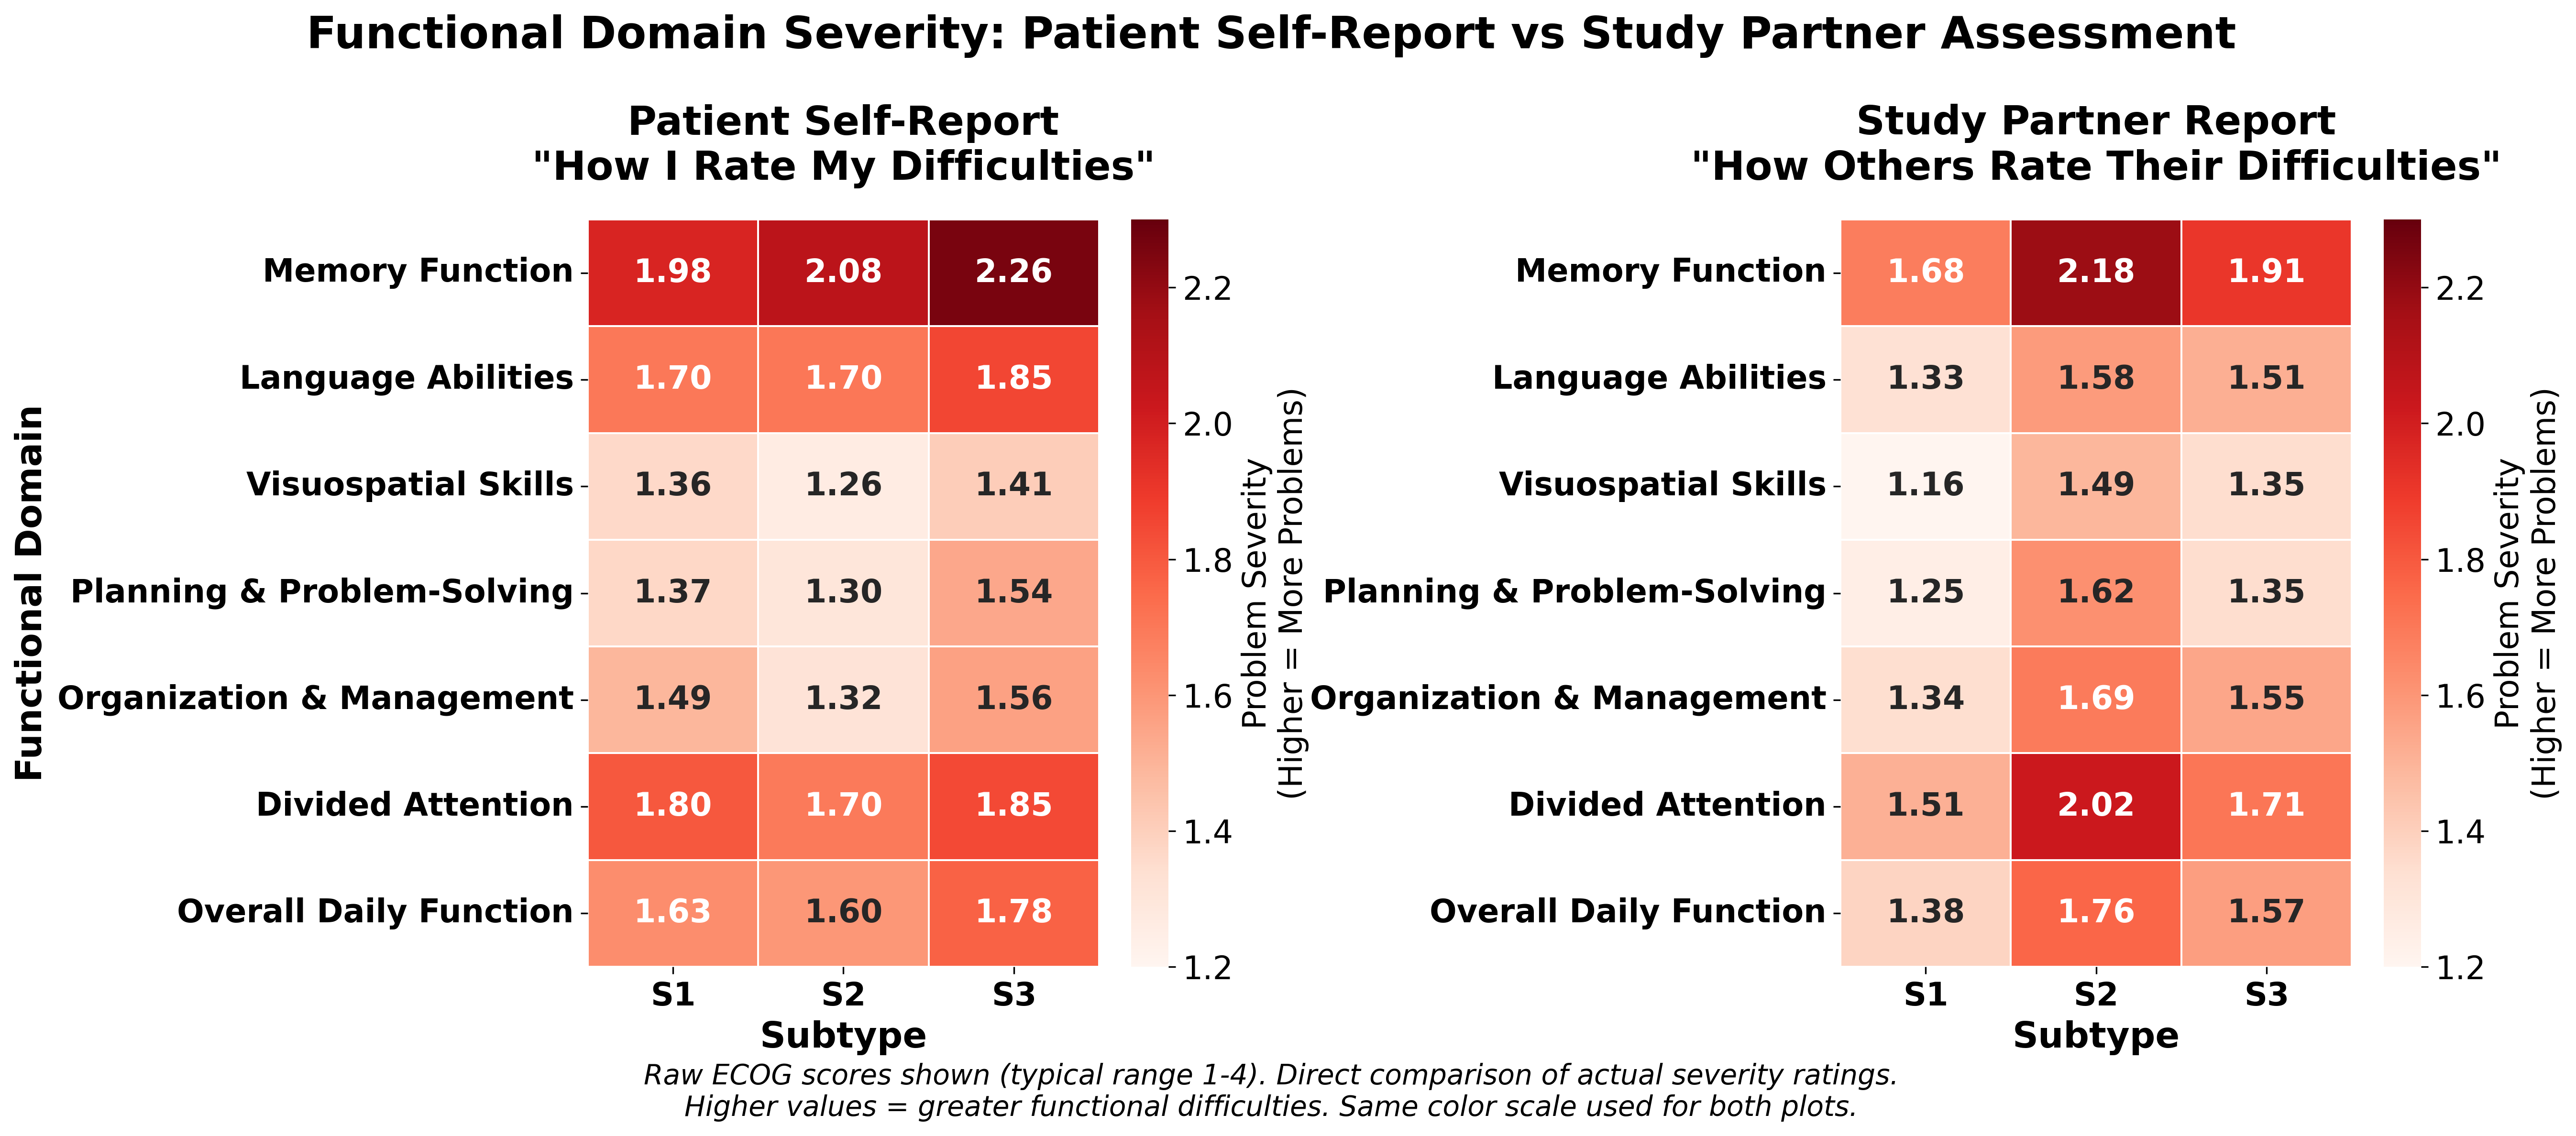

ANALYSIS APPROACH JUSTIFICATION

Domain Statistics:
------------------------------------------------------------
Memory Function          : Mean=2.04, SD=0.76, CV=0.37
Language Abilities       : Mean=1.73, SD=0.63, CV=0.36
Visuospatial Skills      : Mean=1.36, SD=0.52, CV=0.39
Planning & Problem-Solving: Mean=1.39, SD=0.56, CV=0.40
Organization & Management: Mean=1.48, SD=0.62, CV=0.42
Divided Attention        : Mean=1.80, SD=0.80, CV=0.45
Overall Daily Function   : Mean=1.66, SD=0.55, CV=0.33

Range of domain means: 0.68

🔍 RECOMMENDATION: Consider z-score normalization
   Reason: Large differences in mean scores across domains
   This would highlight relative patterns within each domain


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['figure.dpi'] = 300
subtype_colors = {'S1': '#4472C4', 'S2': '#C55A5A', 'S3': '#70AD47'}

# =============================================================================
# DUAL HEATMAP: PATIENT vs STUDY PARTNER FUNCTIONAL REPORTS (RAW VALUES)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Functional Domain Severity: Patient Self-Report vs Study Partner Assessment', 
             fontsize=22, fontweight='bold')

# =============================================================================
# LEFT HEATMAP: PATIENT SELF-REPORT (RAW VALUES)
# =============================================================================

ax1 = axes[0]

patient_domains = {
    'EcogPtMem_bl': 'Memory Function',
    'EcogPtLang_bl': 'Language Abilities', 
    'EcogPtVisspat_bl': 'Visuospatial Skills',
    'EcogPtPlan_bl': 'Planning & Problem-Solving',
    'EcogPtOrgan_bl': 'Organization & Management',
    'EcogPtDivatt_bl': 'Divided Attention',
    'EcogPtTotal_bl': 'Overall Daily Function'
}

available_pt_domains = {k: v for k, v in patient_domains.items() if k in df_anatomical.columns}

if len(available_pt_domains) >= 4:
    pt_heatmap_data = []
    pt_domain_labels = []
    
    for var, label in available_pt_domains.items():
        row = []
        for subtype in ['S1', 'S2', 'S3']:
            mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
            row.append(mean_val)
        pt_heatmap_data.append(row)
        pt_domain_labels.append(label)
    
    pt_heatmap_df = pd.DataFrame(pt_heatmap_data, columns=['S1', 'S2', 'S3'], index=pt_domain_labels)
    
    # Determine if all domains have similar scales (check range)
    all_values = pt_heatmap_df.values.flatten()
    value_range = np.max(all_values) - np.min(all_values)
    
    # Use raw values with appropriate color scaling
    # Assuming ECOG scale where higher = more problems
    vmin = np.floor(np.min(all_values) * 10) / 10  # Round down to nearest 0.1
    vmax = np.ceil(np.max(all_values) * 10) / 10   # Round up to nearest 0.1
    
    sns.heatmap(pt_heatmap_df, annot=True, cmap='Reds', 
               vmin=vmin, vmax=vmax,
               ax=ax1, fmt='.2f', 
               cbar_kws={'label': 'Problem Severity\n(Higher = More Problems)'},
               linewidths=0.5, square=False, annot_kws={'fontweight': 'bold'})

    ax1.set_title('Patient Self-Report\n"How I Rate My Difficulties"', fontweight='bold', pad=20, fontsize=20)
    ax1.set_xlabel('Subtype', fontweight='bold', fontsize=18)
    ax1.set_ylabel('Functional Domain', fontweight='bold', fontsize=18)

    # Bold x/y tick labels
    ax1.set_xticklabels(ax1.get_xticklabels(), fontweight='bold')
    ax1.set_yticklabels(ax1.get_yticklabels(), fontweight='bold')

# =============================================================================
# RIGHT HEATMAP: STUDY PARTNER REPORT (RAW VALUES)
# =============================================================================

ax2 = axes[1]

partner_domains = {
    'EcogSPMem_bl': 'Memory Function',
    'EcogSPLang_bl': 'Language Abilities', 
    'EcogSPVisspat_bl': 'Visuospatial Skills',
    'EcogSPPlan_bl': 'Planning & Problem-Solving',
    'EcogSPOrgan_bl': 'Organization & Management',
    'EcogSPDivatt_bl': 'Divided Attention',
    'EcogSPTotal_bl': 'Overall Daily Function'
}

available_sp_domains = {k: v for k, v in partner_domains.items() if k in df_anatomical.columns}

if len(available_sp_domains) >= 4:
    sp_heatmap_data = []
    sp_domain_labels = []
    
    for var, label in available_sp_domains.items():
        row = []
        for subtype in ['S1', 'S2', 'S3']:
            mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
            row.append(mean_val)
        sp_heatmap_data.append(row)
        sp_domain_labels.append(label)
    
    sp_heatmap_df = pd.DataFrame(sp_heatmap_data, columns=['S1', 'S2', 'S3'], index=sp_domain_labels)
    
    # Use same scale as patient heatmap for direct comparison
    sns.heatmap(sp_heatmap_df, annot=True, cmap='Reds',
               vmin=vmin, vmax=vmax,
               ax=ax2, fmt='.2f',
               cbar_kws={'label': 'Problem Severity\n(Higher = More Problems)'},
               linewidths=0.5, square=False, annot_kws={'fontweight': 'bold'})

    ax2.set_title('Study Partner Report\n"How Others Rate Their Difficulties"', fontweight='bold', pad=20, fontsize=20)
    ax2.set_xlabel('Subtype', fontweight='bold', fontsize=18)
    ax2.set_ylabel('') # Remove y-label from right plot

    # Bold x/y tick labels
    ax2.set_xticklabels(ax2.get_xticklabels(), fontweight='bold')
    ax2.set_yticklabels(ax2.get_yticklabels(), fontweight='bold')

# Add interpretation text
fig.text(0.5, 0.02, 
         'Raw ECOG scores shown (typical range 1-4). Direct comparison of actual severity ratings.\n' +
         'Higher values = greater functional difficulties. Same color scale used for both plots.',
         ha='center', fontsize=14, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for interpretation text
plt.savefig("functional_heatmaps_raw.pdf", format='pdf', bbox_inches='tight')
plt.show()

# =============================================================================
# OPTIONAL: Show both raw and normalized versions with clear justification
# =============================================================================

print("=" * 60)
print("ANALYSIS APPROACH JUSTIFICATION")
print("=" * 60)

# Check if normalization might be needed
if len(available_pt_domains) >= 4:
    # Calculate coefficient of variation for each domain
    domain_stats = []
    for var, label in available_pt_domains.items():
        values = df_anatomical[var].dropna()
        cv = values.std() / values.mean() if values.mean() > 0 else 0
        domain_stats.append((label, values.mean(), values.std(), cv))
    
    print("\nDomain Statistics:")
    print("-" * 60)
    for label, mean, std, cv in domain_stats:
        print(f"{label:<25}: Mean={mean:.2f}, SD={std:.2f}, CV={cv:.2f}")
    
    # Decision logic
    all_means = [stat[1] for stat in domain_stats]
    mean_range = max(all_means) - min(all_means)
    
    print(f"\nRange of domain means: {mean_range:.2f}")
    
    if mean_range > 0.5:  # Arbitrary threshold
        print("\n🔍 RECOMMENDATION: Consider z-score normalization")
        print("   Reason: Large differences in mean scores across domains")
        print("   This would highlight relative patterns within each domain")
    else:
        print("\n✅ RECOMMENDATION: Use raw values")
        print("   Reason: Similar scales across domains - raw values are interpretable")
        print("   Clinical meaning is preserved (e.g., 2.5 = mild-moderate problems)")